In [2]:
library(repr)
library(tidyverse)
library(tidymodels)
library(ggplot2)
options(repr.matrix.max.rows = 6)


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [3]:
# Preliminary Exploratory Data Analysis: Read Data into R
diabetes_data <- read.csv("diabetes.csv")
diabetes_data

Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<int>
6,148,72,35,0,33.6,0.627,50,1
1,85,66,29,0,26.6,0.351,31,0
8,183,64,0,0,23.3,0.672,32,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
5,121,72,23,112,26.2,0.245,30,0
1,126,60,0,0,30.1,0.349,47,1
1,93,70,31,0,30.4,0.315,23,0


In [6]:
# Preliminary Exploratory Data Analysis: Clean and Wrangle Data

diabetes_data$Patient_number <- seq.int(nrow(diabetes_data)) 

diabetes_select <- select(diabetes_data, Patient_number, Glucose, Insulin, Outcome)
diabetes_filter <- diabetes_select |>
    filter(!(Outcome == 0 & Insulin == 0))


diabetes_filter


Patient_number,Glucose,Insulin,Outcome
<int>,<int>,<int>,<int>
1,148,0,1
3,183,0,1
4,89,94,0
⋮,⋮,⋮,⋮
764,101,180,0
766,121,112,0
767,126,0,1


In [7]:
# # Preliminary Exploratory Data Analysis: Training and Testing Data
set.seed(2020)
diabetes_select <- mutate(diabetes_filter, Outcome=as_factor(Outcome))
diabetes_split <- initial_split(diabetes_select, prop = 0.75, strata = Outcome)  
diabetes_train <- training(diabetes_split)   
diabetes_test <- testing(diabetes_split)


In [8]:
#Exploratory Data Analysis: Organize the training data into tables
diabetes_count_case<-group_by(diabetes_train, Outcome) |>
    summarize(number_of_cases=n())
diabetes_count_case

diabetes_indicator_mean<-group_by(diabetes_train, Outcome) |>
    summarize(across(Glucose:Insulin, mean))
diabetes_indicator_mean


Outcome,number_of_cases
<fct>,<int>
0,198
1,201


Outcome,Glucose,Insulin
<fct>,<dbl>,<dbl>
0,111.5909,128.0808
1,141.3284,96.1592


Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”


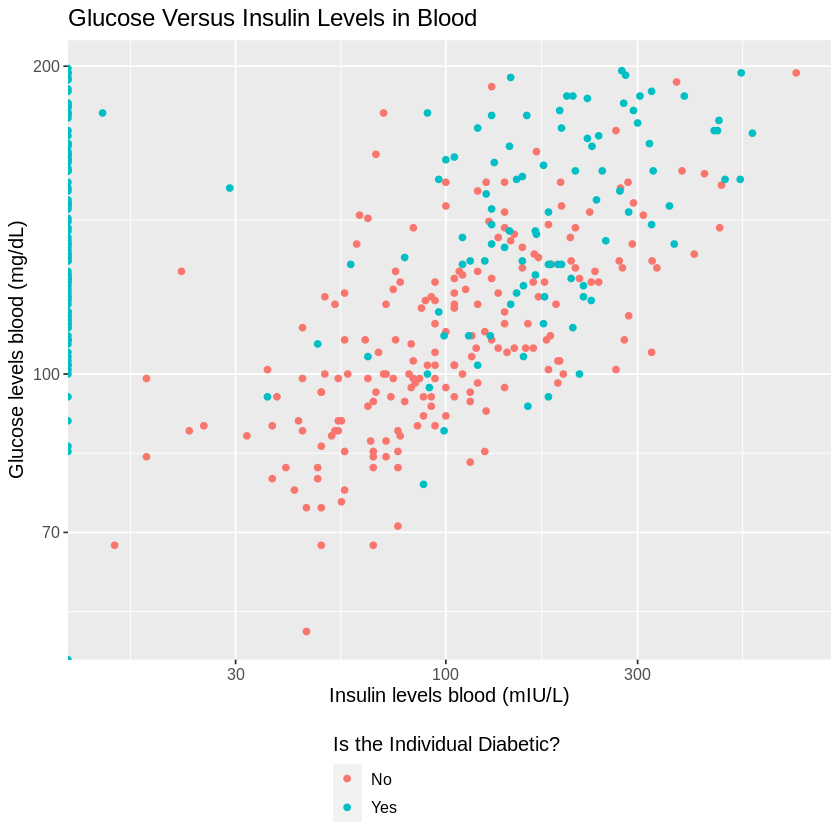

In [9]:
# Preliminary Exploratory Data Analysis: Visualize the training data

diabetes_train_plot <-ggplot (diabetes_train, aes(x = Insulin, 
                     y = Glucose, 
                     color = as_factor(Outcome))) +
geom_point(stat = "identity") +
    labs(x="Insulin levels blood (mIU/L)", y="Glucose levels blood (mg/dL)", color = "Is the Individual Diabetic?") + 
    theme(text = element_text(size = 12),
        legend.position = "bottom",
        legend.direction = "vertical") +
    scale_fill_discrete(name = "Diabetic?", labels = c("No", "Yes")) +
    scale_x_log10(labels = comma) +
    scale_y_log10(labels = comma) +
    ggtitle("Glucose Versus Insulin Levels in Blood") +
    scale_color_discrete(labels = c("No", "Yes"))

diabetes_train_plot



Recipe

Inputs:

      role #variables
   outcome          1
 predictor          2

Operations:

Scaling for all_predictors()
Centering for all_predictors()

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
6,accuracy,binary,0.7895738,5,0.006404982,Preprocessor1_Model04


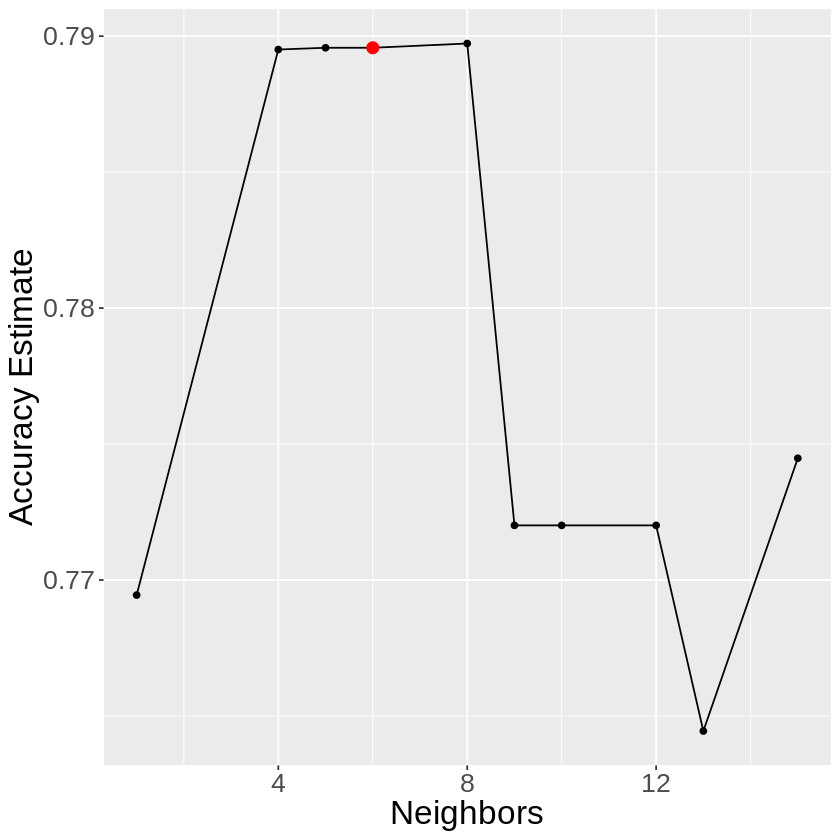

In [26]:
# Scale the data
set.seed(2020)

diabetes_vfold <- vfold_cv(diabetes_train, v = 5, strata = Outcome)

diabetes_recipe <- recipe(Outcome ~ Glucose + Insulin, data = diabetes_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())
diabetes_recipe

# Create classifier
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

# Create the workflow for cross validation to find the optimal K value
knn_results <- workflow() |>
    add_recipe(diabetes_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = diabetes_vfold, grid = 10) |>
    collect_metrics() 

accuracies <- knn_results |>
    filter(.metric == "accuracy")

# Plot k values by accuracies to find the optimal K value
highlight_df <- accuracies |> 
             filter(neighbors == 6 )
highlight_df

# Create final classifier 
final_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 6) |>
       set_engine("kknn") |>
       set_mode("classification")

# Create final workflow
final_fit <-workflow() |>
       add_recipe(diabetes_recipe) |>
       add_model(final_spec) |>
       fit(data=diabetes_train)
# Create predictions 
diabetes_predictions <- predict(final_fit, diabetes_test)|>
       bind_cols(diabetes_test) 

# Collect accuracy of predictions
diabetes_metrics<- diabetes_predictions |>
         metrics(truth = Outcome, estimate = .pred_class)  

# Create confidence matrix of predictions
diabetes_conf_mat <- diabetes_predictions |> 
       conf_mat(truth = Outcome, estimate = .pred_class)


cross_val_plot <- accuracies |> 
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    geom_point(data=highlight_df, 
             aes(x=neighbors,y=mean), 
             color='red',
             size=3) +
    labs(x = "Neighbors", y = "Accuracy Estimate") +
    theme(text = element_text(size = 20)) 

cross_val_plot


In [23]:
# I think you should use K = 6, but if you dont change the highlighted point above